In [1]:
import matplotlib as mpl  
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')


import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *
# from darcy_2d import  MyNet
# from darcy_2d import MyNet


In [2]:

class MyNet(torch.nn.Module):
    def __init__(self, s, width=32, rank=1):
        super(MyNet, self).__init__()
        self.s = s
        self.width = width
        self.rank = rank

        self.fc0 = nn.Linear(3, self.width)

        self.net1 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net2 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net3 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net4 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.w1 = nn.Linear(self.width, self.width)
        self.w2 = nn.Linear(self.width, self.width)
        self.w3 = nn.Linear(self.width, self.width)
        self.w4 = nn.Linear(self.width, self.width)

        self.bn1 = torch.nn.BatchNorm1d(self.width)
        self.bn2 = torch.nn.BatchNorm1d(self.width)
        self.bn3 = torch.nn.BatchNorm1d(self.width)
        self.bn4 = torch.nn.BatchNorm1d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)


    def forward(self, v):
        batch_size, n = v.shape[0], v.shape[1]
        a = v.clone()

        v = self.fc0(v)

        v1 = self.net1(v, a)
        v2 = self.w1(v)
        v = v1+v2
        v = self.bn1(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net2(v, a)
        v2 = self.w2(v)
        v = v1+v2
        v = self.bn2(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net3(v, a)
        v2 = self.w3(v)
        v = v1+v2
        v = self.bn3(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net4(v, a)
        v2 = self.w4(v)
        v = v1+v2
        v = self.bn4(v.reshape(-1, self.width)).view(batch_size,n,self.width)


        v = self.fc1(v)
        v = F.relu(v)
        v = self.fc2(v)

        return v.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c


class LowRank2d(nn.Module):
    def __init__(self, in_channels, out_channels, s, width, rank):
        super(LowRank2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.s = s
        self.n = s*s
        self.rank = rank

        self.phi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)
        self.psi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)


    def forward(self, v, a):
        # a (batch, n, 3)
        # v (batch, n, f)
        batch_size = v.shape[0]

        phi_eval = self.phi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)
        psi_eval = self.psi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)

        # print(psi_eval.shape, v.shape, phi_eval.shape)
        v = torch.einsum('bnoir,bni,bmoir->bmo', psi_eval, v, phi_eval) / self.n

        return v


In [3]:
TRAIN_PATH = 'piececonst_r421_N1024_smooth1.mat'
TEST_PATH = 'piececonst_r421_N1024_smooth2.mat'

ntrain = 1000
ntest = 100

batch_size = 10

r = 5
h = int(((421 - 1)/r) + 1)
s = h

reader = MatReader(TRAIN_PATH)
x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s].reshape(ntrain,s*s)
y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s].reshape(ntrain,s*s)
reader.load_file(TEST_PATH)
x_test = reader.read_field('coeff')[:ntest,::r,::r][:,:s,:s].reshape(ntest,s*s)
y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s].reshape(ntest,s*s)


print(x_test.shape, y_test.shape)

torch.Size([100, 7225]) torch.Size([100, 7225])


In [4]:
x_normalizer = UnitGaussianNormalizer(x_test)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_test)
y_test = y_normalizer.encode(y_test)

# x_normalizer = UnitGaussianNormalizer(x_train)
# x_train = x_normalizer.encode(x_train)
# x_test = x_normalizer.encode(x_test)
# 
# y_normalizer = UnitGaussianNormalizer(y_train)
# y_train = y_normalizer.encode(y_train)
# y_test = y_normalizer.encode(y_test)


grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s*s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_test_full = torch.cat([x_test.reshape(ntest,s*s,1), grid.repeat(ntest,1,1)], dim=2)

In [5]:
model = torch.load('darcy2d_trained').cpu()
# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_full, y_test), batch_size=batch_size, shuffle=False)
x, y = next(iter(test_loader))


model_output = model(x).reshape(batch_size, s*s)
print(model_output.device)
# model_output = y_normalizer.encode(model_output)

# x, y = x.cuda(), y.cuda()

grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s*s,2)
grid = torch.tensor(grid, dtype=torch.float)

X, Y = torch.meshgrid((torch.linspace(0, 1, s), torch.linspace(0, 1, s)))

x.shape, y.shape, model_output.shape, grid.shape, X.shape

cpu


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([10, 7225, 3]),
 torch.Size([10, 7225]),
 torch.Size([10, 7225]),
 torch.Size([1, 7225, 2]),
 torch.Size([85, 85]))

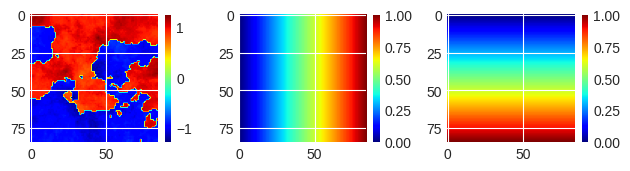

In [6]:
idx = 0

plt.subplot(131) 
plt.imshow(x[idx, :, 0].reshape(85, 85), cmap='jet')


plt.colorbar(fraction=0.045)


plt.subplot(132) 
plt.imshow(x[idx, :, 1].reshape(85, 85), cmap='jet')

plt.colorbar(fraction=0.045)


plt.subplot(133) 
plt.imshow(x[idx, :, 2].reshape(85, 85), cmap='jet')

# gradient 0 -> 1

plt.colorbar(fraction=0.045)

plt.tight_layout()


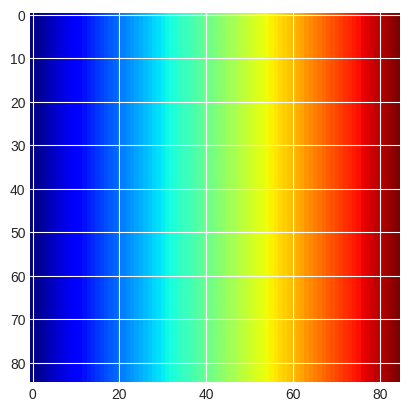

In [7]:
X, Y = torch.meshgrid((torch.linspace(0, 1, 85), torch.linspace(0, 1, 85)))

plt.imshow(Y, cmap='jet')

(81, 81)


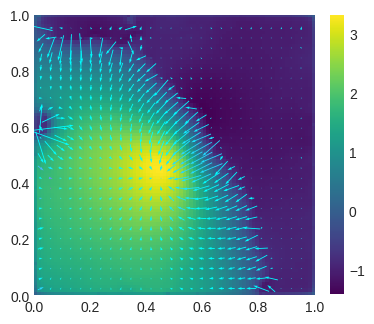

In [8]:
X, Y = torch.meshgrid(torch.linspace(0, 1, s), torch.linspace(0, 1, s))
t_idx = 2

Ux = -torch.diff(y[t_idx].reshape(85, 85), dim=0, prepend=torch.zeros(1, 85))
Uy = torch.diff(y[t_idx].reshape(85, 85), dim=1, prepend=torch.zeros(85, 1))
# torch.diff(y[0].reshape(85, 85), dim=0, prepend=torch.zeros(1, 85)).shape
plt.figure(figsize=(4, 6))
# plt.subplot(131)
# plt.imshow(Ux, cmap='jet', extent=[0, 1, 0, 1]) #dx
# plt.colorbar(fraction = 0.045, )
# 
# plt.subplot(132)
# plt.imshow(Uy, cmap='jet', extent=[0, 1, 0, 1]) #dy
# plt.colorbar(fraction = 0.045, )
# 
# 
# plt.subplot(133)
im3  = plt.imshow(y[t_idx].reshape(85, 85).cpu().detach().numpy(),  extent=[0, 1, 0, 1], cmap='viridis', interpolation='nearest')  #cmap='jet',
# contours = plt.contour(X, Y, y[t_idx].reshape(85, 85).cpu().detach().numpy(), 20, colors='grey')
N = 3

X, Y, Ux, Uy = X[2:-2,2:-2], Y[2:-2,2:-2], Ux[2:-2,2:-2], Uy[2:-2,2:-2]

C = Ux**2 + Uy**2

coloring = lambda x, y: x**2 + y**2
colors = coloring(Ux, Uy)
norm  = mpl.colors.Normalize()
norm.autoscale(colors)
cmap = mpl.cm.cool
print(norm(colors).shape)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.quiver(Y[::N, ::N], X[::N, ::N], Uy[::N, ::N].flip(0), Ux[::N, ::N].flip(0), C[::N, ::N], width=0.003, pivot='mid', units='width', cmap=cmap, norm=norm) # , pivot='mid',units='x'
plt.grid(False)

plt.colorbar(im3, fraction = 0.045, cmap='viridis', location='right')
# plt.colorbar(sm, fraction = 0.045, location='bottom')

# print(torch.diff(y[0].reshape(85, 85), dim=-1,).shape)
#def compute_derivs(Ufield): 
#    dx = torch.diff(Ufield, )
# plt.subplot(144)
# 
# plt.quiver(Y, X, Uy, Ux)
# N = 3
# X, Y, Ux, Uy = X[2:-2,2:-2], Y[2:-2,2:-2], Ux[2:-2,2:-2], Uy[2:-2,2:-2]
# 
# coloring = lambda x, y: x**2 + y**2
# colors = coloring(Ux, Uy)
# norm  = mpl.colors.Normalize()
# norm.autoscale(colors)
# cmap = mpl.cm.viridis
# print(norm(colors).shape)
# 
# plt.quiver(Y[::N, ::N], X[::N, ::N], Uy[::N, ::N].flip(0), Ux[::N, ::N].flip(0), width=0.0035, pivot='mid', units='width') # , pivot='mid',units='x'


# plt.streamplot(X, Y, Ux, Uy)
# plt.tight_layout()


In [9]:
it = iter(test_loader)
_, _ = next(it)
_, _ = next(it)

x, y = next(it)
model_output = model(x).reshape(batch_size, s*s)


In [10]:
batch_idx = 1

(81, 81)
17225.6015625
0.10597380995750427
(81, 81)
(81, 81)


Text(0.5, 0.98, '2D Darcy Flow\n$ \\begin{cases}- \\nabla \\cdot (a(x) \\nabla u(x)) &= f(x) \\quad x \\in (0, 1)^2 \\\\ u(x) &= 0 \\quad \\quad x \\in \\partial (0, 1)^2 \\end{cases}$\nPrediction MSE: 0.1060')

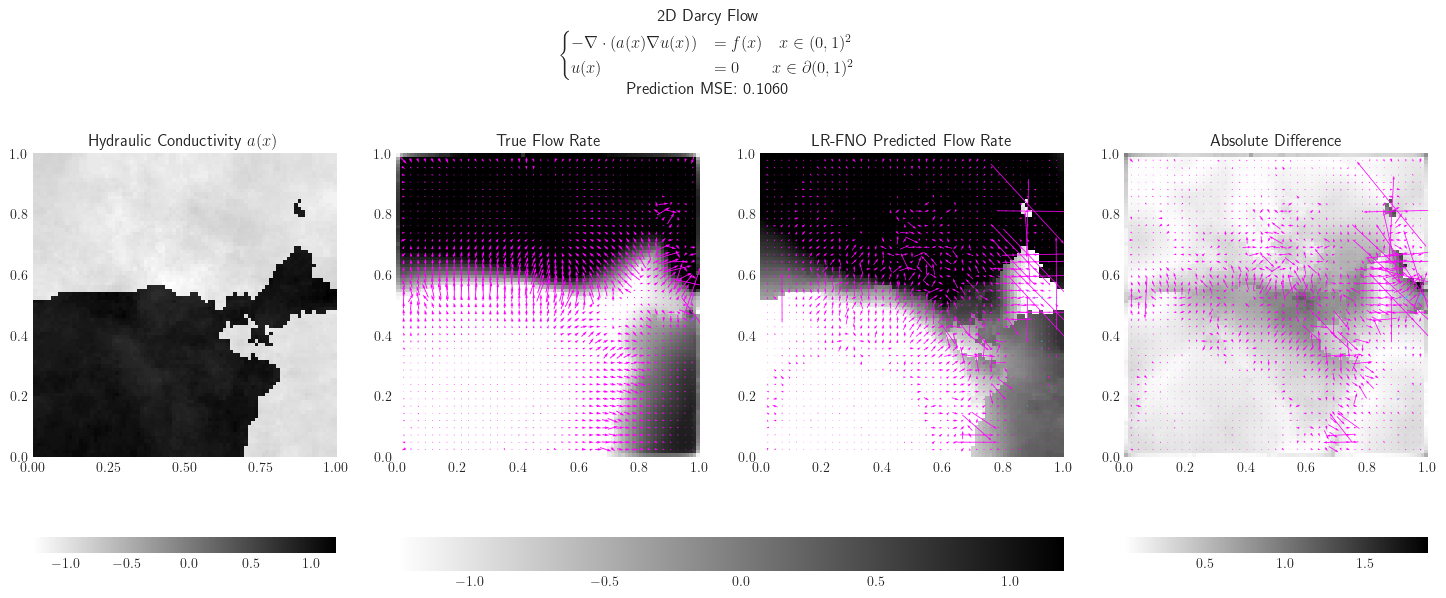

In [14]:
# mpl.rc('text', usetex = True)
# mpl.rc('font', **{'family' : "sans-serif"})
# params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
# plt.rcParams.update(params)
from matplotlib.colors import LogNorm, NoNorm

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

myloss = LpLoss(size_average=False)

# x, y = next(iter(test_loader))
# batch_idx = 3


X, Y = torch.meshgrid(torch.linspace(0, 1, s), torch.linspace(0, 1, s))

Ux = -torch.diff(y[batch_idx].reshape(85, 85), dim=0, prepend=torch.zeros(1, 85))
Uy = torch.diff(y[batch_idx].reshape(85, 85), dim=1, prepend=torch.zeros(85, 1))

N = 2
X, Y, Ux, Uy = X[2:-2,2:-2], Y[2:-2,2:-2], Ux[2:-2,2:-2], Uy[2:-2,2:-2]

C = Ux**2 + Uy**2

coloring = lambda x, y: x**2 + y**2
colors = coloring(Ux, Uy)
norm  = mpl.colors.Normalize()
norm.autoscale(colors)
cmap = mpl.cm.cool_r
print(norm(colors).shape)


# snapsviridis_idx = 9

loss = myloss(y[batch_idx],model_output[batch_idx] ) # L2 error...? 
mse = F.mse_loss(model_output[batch_idx], y[batch_idx], reduction='mean')

print(loss.item())
print(mse.item())

plt.figure(figsize=(18, 7))

plt.subplot(141)
plt.imshow(x[batch_idx, :, 0].reshape(85, 85).cpu().detach().numpy(), cmap='binary', extent=[0, 1, 0, 1])
plt.title("Hydraulic Conductivity" + r" $a(x)$")
plt.colorbar(location='bottom') # fraction = 0.045, 
plt.grid(False)
# plt.gca().set_xticks(np.linspace(0, 1, 5)) # NO 
plt.xticks(np.linspace(0, 1, 5))

# norm = LogNorm(min(x[batch_idx, :, 0].min(), y[batch_idx].max()), max(x[batch_idx, :, 0].max(), y[batch_idx].max()))
norm = NoNorm(min(model_output[batch_idx].min(), y[batch_idx].max()), model_output[batch_idx].max(), y[batch_idx].max())
ax2 = plt.subplot(142)
im2  = ax2.imshow(y[batch_idx].reshape(85, 85).cpu().detach().numpy(), cmap='binary', norm=norm, extent=[0, 1, 0, 1])
plt.title("True Flow Rate")
ax2.quiver(Y[::N, ::N], X[::N, ::N], Uy[::N, ::N].flip(0), Ux[::N, ::N].flip(0), C[::N, ::N], width=0.003, pivot='mid', units='width', cmap=cmap, norm=norm) # , pivot='mid',units='x'
plt.grid(False)


# plt.colorbar(fraction = 0.05)
plt.grid(False)

ax3 = plt.subplot(143)
im3 = ax3.imshow(model_output[batch_idx].reshape(85, 85).cpu().detach().numpy(), cmap='binary',norm=norm, extent=[0, 1, 0, 1])
plt.title("LR-FNO Predicted Flow Rate")

# plt.colorbar(ax=ax3, fraction = 0.05)

X, Y = torch.meshgrid(torch.linspace(0, 1, s), torch.linspace(0, 1, s))

Ux = -torch.diff(model_output[batch_idx].reshape(85, 85), dim=0, prepend=torch.zeros(1, 85))
Uy = torch.diff(model_output[batch_idx].reshape(85, 85), dim=1, prepend=torch.zeros(85, 1))

N = 2

X, Y, Ux, Uy = X[2:-2,2:-2], Y[2:-2,2:-2], Ux[2:-2,2:-2], Uy[2:-2,2:-2]

C = Ux**2 + Uy**2

coloring = lambda x, y: x**2 + y**2
colors = coloring(Ux, Uy).cpu().detach().numpy()
norm  = mpl.colors.Normalize()
norm.autoscale(colors)
cmap = mpl.cm.cool_r
print(norm(colors).shape)

ax3.quiver(Y[::N, ::N], X[::N, ::N], Uy[::N, ::N].flip(0).cpu().detach().numpy(), Ux[::N, ::N].flip(0).cpu().detach().numpy(), C[::N, ::N].cpu().detach().numpy(), width=0.0025, pivot='mid', units='xy', cmap=cmap, norm=norm) # , pivot='mid',units='x'

plt.colorbar(ax=[ax2, ax3],  orientation='horizontal', cmap='binary') # , fraction = 0.045, 

plt.grid(False)

ax4 = plt.subplot(144)
imlast = plt.imshow(torch.abs(model_output[batch_idx] - y[batch_idx]).reshape(85, 85).cpu().detach().numpy(), cmap='binary', extent=[0, 1, 0, 1])
plt.title("Absolute Difference")

X, Y = torch.meshgrid(torch.linspace(0, 1, s), torch.linspace(0, 1, s))

Ux = -torch.diff((y[batch_idx]-model_output[batch_idx]).reshape(85, 85), dim=0, prepend=torch.zeros(1, 85))
Uy = torch.diff((y[batch_idx] - model_output[batch_idx]).reshape(85, 85), dim=1, prepend=torch.zeros(85, 1))

N = 2

X, Y, Ux, Uy = X[2:-2,2:-2], Y[2:-2,2:-2], Ux[2:-2,2:-2], Uy[2:-2,2:-2]

C = Ux**2 + Uy**2

coloring = lambda x, y: x**2 + y**2
colors = coloring(Ux, Uy).cpu().detach().numpy()
norm  = mpl.colors.Normalize()
norm.autoscale(colors)
cmap = mpl.cm.cool_r
print(norm(colors).shape)

plt.colorbar(ax=ax4, location='bottom') # fraction = 0.05, 

plt.quiver(Y[::N, ::N], X[::N, ::N], Uy[::N, ::N].flip(0).cpu().detach().numpy(), Ux[::N, ::N].flip(0).cpu().detach().numpy(), C[::N, ::N].cpu().detach().numpy(), width=0.0025, pivot='mid', units='xy', cmap=cmap, norm=norm) # , pivot='mid',units='x'


plt.grid(False)

plt.suptitle("2D Darcy Flow" + '\n' + r"$ \begin{cases}- \nabla \cdot (a(x) \nabla u(x)) &= f(x) \quad x \in (0, 1)^2 \\ u(x) &= 0 \quad \quad x \in \partial (0, 1)^2 \end{cases}$" + '\n' + f"Prediction MSE: {mse.item():.4f}")
# plt.suptitle(r"$f(x)= \begin{cases} a\times x^{1.5}2 + c,& \text{if } -1 \leq x \leq 1\\  0, & \text{otherwise}  \end{cases}$")

# plt.tight_layout()


In [12]:
# plt.contourf(test_samples[0][0].reshape(85, 85).cpu().detach().numpy(), test_samples[1][0].reshape(85, 85).cpu().detach().numpy())
plt.imshow(test_samples[1][4].reshape(85, 85).cpu().detach().numpy(), cmap='jet')
plt.colorbar()

NameError: name 'test_samples' is not defined

In [ ]:
#test_samples = test_loader[32].dataset
# test_samples = test_loader.dataset[32]
test_samples = next(iter(test_loader))

n = 3
fig = plt.figure(figsize=(10,10))
for index in range(3):
    data = test_samples[index+n]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).to(device))

    ax = fig.add_subplot(3,3,  index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    im = ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    plt.colorbar(im, ax=ax)

    ax = fig.add_subplot(3,3, index*3 + 3)
    ax.imshow(out.squeeze().cpu().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.colorbar(im, ax=ax)


    # ax = fig.add_subplot(4, 4, index*4 + 4)
    # ax.imshow(torch.abs(y.squeeze() - out.squeeze().detach().numpy()))
    # if index == 0: 
        # ax.set_title('Absolute Value difference')
    # plt.xticks([], [])
    # plt.yticks([], [])
    # plt.colorbar()


fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

IndexError: list index out of range

<Figure size 1000x1000 with 0 Axes>